In [1]:
import joblib
import json


In [2]:

# Load model
rf_model_loaded = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler_loaded = joblib.load('X_scaler.pkl')
Y_scaler_loaded = joblib.load('Y_scaler.pkl')

In [3]:
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)


In [4]:
def is_wa_ski_site(area):
    return area['properties']['location'] and area['properties']['location']['iso3166_2'] == 'US-WA' and area['geometry']['type'] != 'Point'
wa_ski_sites = [area for area in ski_areas['features'] if is_wa_ski_site(area)]

len(wa_ski_sites)

17

In [5]:
crystal_mountain_area = [site for site in wa_ski_sites if site['properties']['name'] == 'Crystal Mountain'][0]
# crystal_mountain_area


In [6]:
from shapely.geometry import shape

# Alternative: Get bounds directly from shapely geometry
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_bounds = crystal_polygon.bounds  # Returns (minx, miny, maxx, maxy)

print(f"\nDirect bounds: {crystal_bounds}")



Direct bounds: (-121.5089145, 46.90889530000001, -121.46718410000003, 46.9567407)


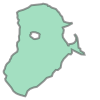

In [7]:
crystal_polygon

In [8]:
import earthaccess
earthaccess.login()


/Users/aimeebarciauskas/github/ski-project/ski-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [91]:
hls_granules = []

start_date, end_date = '2025-06-01', '2025-12-31'
for hls_collection in ['HLSL30', 'HLSS30']:
    hls_granules.extend(earthaccess.search_data(
        short_name=hls_collection,
        bounding_box=crystal_bounds,
        temporal=(start_date, end_date)
    ))

len(hls_granules)

87

In [13]:
import importlib
import helpers

importlib.reload(helpers)

<module 'helpers' from '/Users/aimeebarciauskas/github/ski-project/helpers.py'>

In [92]:
crystal_polygon_id = crystal_mountain_area['properties']['name']
fs = earthaccess.get_fsspec_https_session()
hls_polygon_data = helpers.HlsPolygonMergedData(fs, hls_granules[0], crystal_polygon, crystal_polygon_id)
hls_polygon_data.process_hls_data()
hls_polygon_data.merged_dataset


Processing polygon Crystal Mountain for date 2025-06-02T18:55:31.019Z
Processing 10 bands for merging...
Loading band B01...
Loading band B02...
Loading band B03...
Loading band B04...
Loading band B05...
Loading band B06...
Loading band B07...
Loading band B09...
Loading band B10...
Loading band Fmask...
Merged dataset shape: FrozenMappingWarningOnValuesAccess({'x': 3660, 'y': 3660})
Merged dataset variables: Data variables:
    B01      (y, x) int16 27MB ...
    B02      (y, x) int16 27MB ...
    B03      (y, x) int16 27MB ...
    B04      (y, x) int16 27MB ...
    B05      (y, x) int16 27MB ...
    B06      (y, x) int16 27MB ...
    B07      (y, x) int16 27MB ...
    B09      (y, x) int16 27MB ...
    B10      (y, x) int16 27MB ...
    Fmask    (y, x) uint8 13MB ...


<xarray.Dataset> Size: 255MB
Dimensions:      (x: 3660, y: 3660)
Coordinates:
  * x            (x) float64 29kB 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 29kB 5.2e+06 5.2e+06 5.2e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Data variables:
    B01          (y, x) int16 27MB ...
    B02          (y, x) int16 27MB ...
    B03          (y, x) int16 27MB ...
    B04          (y, x) int16 27MB ...
    B05          (y, x) int16 27MB ...
    B06          (y, x) int16 27MB ...
    B07          (y, x) int16 27MB ...
    B09          (y, x) int16 27MB ...
    B10          (y, x) int16 27MB ...
    Fmask        (y, x) uint8 13MB ...

In [93]:
hls_polygon_data.polygon_area_m2
hls_polygon_data.polygon_projected
clipped = hls_polygon_data.merged_dataset.rio.clip([hls_polygon_data.polygon_projected], hls_polygon_data.target_crs, drop=True)

In [94]:
clipped.B01.shape

(129, 105)

In [95]:
stacked = clipped.stack(pixel=['y', 'x'])  

# Filter to only valid pixels
valid_pixels = stacked.where(stacked['Fmask'] != 255, drop=True)
input_df = valid_pixels.to_dataframe()


In [98]:

input_df['is_snow'] = input_df['Fmask'].apply(lambda x: 1 if int(x) & 16 > 0 else 0)
input_df['B08'] = -9999


In [99]:
input_df.head()

B01     B02     B03     B04     B05     B06     B07  \
y         x                                                                  
5200005.0 614115.0  1946.0  2115.0  2526.0  2646.0  3192.0   279.0   182.0   
          614145.0  2534.0  2764.0  3177.0  3315.0  3587.0   292.0   204.0   
          614175.0  1004.0  1112.0  1326.0  1347.0  1874.0   899.0   594.0   
          614205.0   393.0   487.0   707.0   777.0  1458.0  1583.0  1070.0   
          614235.0   405.0   516.0   815.0  1001.0  2060.0  2481.0  1760.0   

                     B09     B10  Fmask  spatial_ref          y         x  \
y         x                                                                 
5200005.0 614115.0  19.0  1042.0   80.0            0  5200005.0  614115.0   
          614145.0  21.0  1371.0   64.0            0  5200005.0  614145.0   
          614175.0  24.0  1667.0   64.0            0  5200005.0  614175.0   
          614205.0  20.0  1896.0   64.0            0  5200005.0  614205.0   
          614235.0  24.0  2121.0   64.0            0  5200005.0  614235.0   

                    is_snow   B08  
y         x                        
5200005.0 614115.0        1 -9999  
          614145.0        0 -9999  
          614175.0        0 -9999  
          614205.0        0 -9999  
          614235.0        0 -9999

In [100]:
import joblib
import numpy as np

model = joblib.load('random_forest_model.pkl')
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')
band_input_columns = [f"B{i:02d}" for i in range(1, 11)] + ["is_snow"]
x_input_data = input_df[band_input_columns]
x_scaled = X_scaler.transform(x_input_data)
x_scaled


/Users/aimeebarciauskas/github/ski-project/ski-project/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.5158713 , 0.51241487, 0.5327067 , ..., 0.68466375, 0.85278443,
        1.        ],
       [0.54126539, 0.53986718, 0.56039469, ..., 0.68480044, 0.87819572,
        0.        ],
       [0.47518894, 0.46998858, 0.48166894, ..., 0.68500547, 0.90105816,
        0.        ],
       ...,
       [0.44469877, 0.44372065, 0.46116876, ..., 0.6852105 , 0.85579671,
        0.        ],
       [0.48235802, 0.48183241, 0.5022967 , ..., 0.68527884, 0.84475168,
        1.        ],
       [0.50006478, 0.49794848, 0.5206703 , ..., 0.68486878, 0.83888159,
        1.        ]], shape=(7409, 11))

In [101]:
y_pred = model.predict(x_scaled)
y_pred

array([0.16201184, 0.13940829, 0.        , ..., 0.        , 0.00360947,
       0.10491124], shape=(7409,))

In [102]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
y_scaled

array([[27.3800002 ],
       [23.56000036],
       [ 0.        ],
       ...,
       [ 0.        ],
       [ 0.60999999],
       [17.73000025]], shape=(7409, 1))